In [51]:
import numpy as np
import pandas as pd

file_path = '附件一（训练集）.xlsx'
data_list = []
for sheet_name in ['材料1', '材料2', '材料3', '材料4']:
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    df['material'] = sheet_name
    data_list.append(df)
df = pd.concat(data_list, ignore_index=True)

In [72]:
# df.to_csv('all_train.csv', index=False, encoding='utf-8-sig')

In [1]:
import pandas as pd
df = pd.read_csv('all_train.csv')
# df.iloc[:, 2] = df.iloc[:, 2].round()

In [70]:
df = df.rename(columns={'温度，oC':'temperature', '频率，Hz':'frequency', '磁芯损耗，w/m3': 'core_loss', '励磁波形': 'waveform', '0（磁通密度B，T）':'0'})

In [2]:
df[:2]

,temperature,frequency,core_loss,waveform,0,1,2,3,4,5,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,material
0,25,50030,1998.0,正弦波,0.000213,0.000389,0.000566,0.000743,0.000919,0.001096,...,-0.001374,-0.001198,-0.001022,-0.000846,-0.000669,-0.000492,-0.000316,-0.000140,0.000036,材料1
1,25,50020,2428.0,正弦波,-0.000551,-0.000358,-0.000165,0.000028,0.000221,0.000413,...,-0.002284,-0.002091,-0.001899,-0.001707,-0.001515,-0.001322,-0.001129,-0.000937,-0.000744,材料1


In [56]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader


In [57]:
# Extract features
temperature = df['温度，oC'].values.reshape(-1, 1)
frequency = df['频率，Hz'].values.reshape(-1, 1)
waveform = df['励磁波形'].values.reshape(-1, 1)
material = df['material'].values.reshape(-1, 1)
flux_density = df.iloc[:, 4:-1].values  # From the 5th column to the last column
core_loss = df['磁芯损耗，w/m3'].values


In [64]:
# 导入必要的库
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 假设你已经加载了数据集，X是你的特征，y是目标变量
# 数据加载和划分 (这里假设你的目标变量在最后一列)
df = pd.read_csv('feature_and_loss.csv')

# 特征和目标
X = df.iloc[:, :-1]  # 所有列，除了最后一列
y = df.iloc[:, -1]   # 最后一列是目标磁芯损失值

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 初始化随机森林回归模型
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# 训练模型
rf_model.fit(X_train, y_train)

# 预测
y_pred = rf_model.predict(X_test)

# 评估模型性能
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"均方误差 (MSE): {mse}")
print(f"决定系数 (R^2): {r2}")

均方误差 (MSE): 2325101077.0049744
决定系数 (R^2): 0.9827179562849123


In [58]:
# 导入必要的库
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 假设你已经加载了数据集，X是你的特征，y是目标变量
# 数据加载和划分 (这里假设你的目标变量在最后一列)
df = pd.read_csv('feature_and_loss.csv')

# 特征和目标
X = df.iloc[:, :-1]  # 所有列，除了最后一列
y = df.iloc[:, -1]   # 最后一列是目标磁芯损失值

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 将数据转换为DMatrix格式，适用于XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# 设置模型参数
params = {
    'objective': 'reg:squarederror',  # 目标函数是平方误差（回归任务）
    'eval_metric': 'rmse',  # 评估标准是均方根误差（RMSE）
    'learning_rate': 0.1,  # 学习率
    'max_depth': 6,  # 树的最大深度
    'n_estimators': 100,  # 树的数量
    'random_state': 42
}

# 训练模型
xg_model = xgb.train(params, dtrain, num_boost_round=100)

# 预测
y_pred = xg_model.predict(dtest)

# 评估模型性能
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"均方误差 (MSE): {mse}")
print(f"决定系数 (R^2): {r2}")

均方误差 (MSE): 1077278567.8921232
决定系数 (R^2): 0.9919927888349609


/home/dell/miniconda3/envs/agent/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:49:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


In [12]:
y.shape

(12400,)

In [82]:
df = pd.read_csv('features25_and_full_loss.csv')
y = df.iloc[:, -1]
# 计算第一四分位数 (Q1) 和第三四分位数 (Q3)
Q1 = df['core_loss'].quantile(0.25)
Q3 = df['core_loss'].quantile(0.75)
IQR = Q3 - Q1

# 定义异常值的范围
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 去除异常值
df_cleaned = df[(df['core_loss'] >= lower_bound) & (df['core_loss'] <= upper_bound)]

# 打印清理后数据的形状
print(f'清理后数据量: {df_cleaned.shape}')

清理后数据量: (10933, 26)


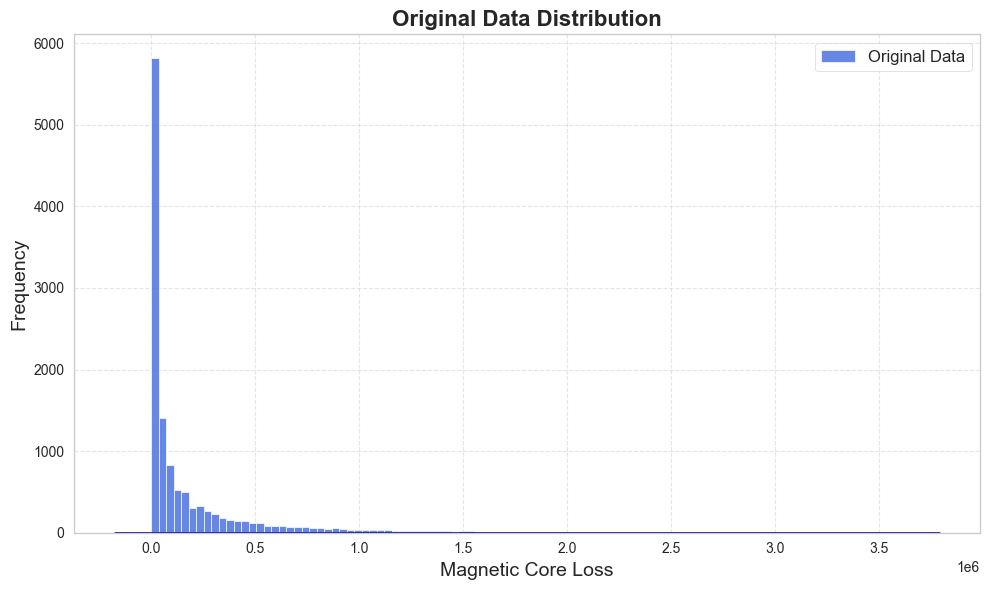

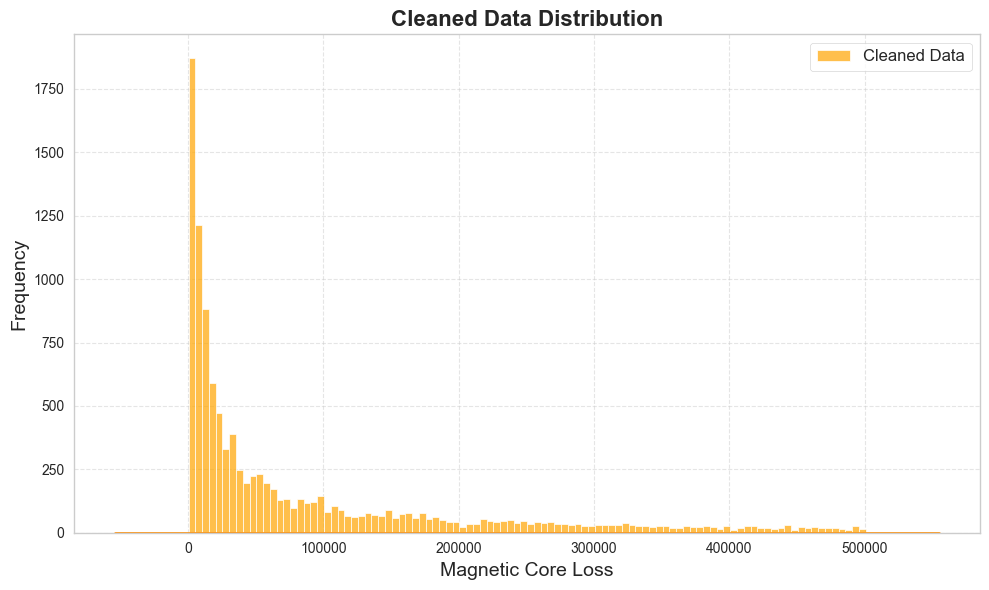

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

# 设置全局样式
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# 绘制原始数据的直方图
sns.histplot(df['core_loss'], bins=100, alpha=0.8, label='Original Data', color='royalblue')
sns.kdeplot(df['core_loss'], color='darkblue', linewidth=2)

plt.title('Original Data Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Magnetic Core Loss', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 绘制清理后的数据的直方图
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['core_loss'], bins=100, alpha=0.7, label='Cleaned Data', color='orange')
sns.kdeplot(df_cleaned['core_loss'], color='darkorange', linewidth=2)

plt.title('Cleaned Data Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Magnetic Core Loss', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [84]:
len(df_cleaned['core_loss'])

10933

In [85]:
def custom_loss(output, target):
    # 原始的MSE损失
    mse_loss = torch.mean((output - target) ** 2)
    
    # 对小于300的输出施加惩罚
    penalty_lower = torch.mean((torch.relu(300 - output)) ** 2)
    
    # 对大于600000的输出施加惩罚
    penalty_upper = torch.mean((torch.relu(output - 600000)) ** 2)
    
    # 总损失 = MSE损失 + 惩罚
    return mse_loss + penalty_lower + penalty_upper  # 通过调整100的权重来控制惩罚力度

Epoch [1/30000], Training Loss: 20769153024.0000, Validation Loss: 21087102976.0000
Epoch [201/30000], Training Loss: 14442627072.0000, Validation Loss: 15082874880.0000
Epoch [401/30000], Training Loss: 5932065792.0000, Validation Loss: 6596402688.0000
Epoch [601/30000], Training Loss: 3420373504.0000, Validation Loss: 3752602112.0000
Epoch [801/30000], Training Loss: 1174502656.0000, Validation Loss: 1291118464.0000
Epoch [1001/30000], Training Loss: 356414624.0000, Validation Loss: 371964288.0000
Epoch [1201/30000], Training Loss: 178359440.0000, Validation Loss: 174013136.0000
Epoch [1401/30000], Training Loss: 114337712.0000, Validation Loss: 110017000.0000
Epoch [1601/30000], Training Loss: 84250680.0000, Validation Loss: 81424064.0000
Epoch [1801/30000], Training Loss: 67754448.0000, Validation Loss: 66063500.0000
Epoch [2001/30000], Training Loss: 56247980.0000, Validation Loss: 55264436.0000
Epoch [2201/30000], Training Loss: 46422904.0000, Validation Loss: 45993828.0000
Epoch

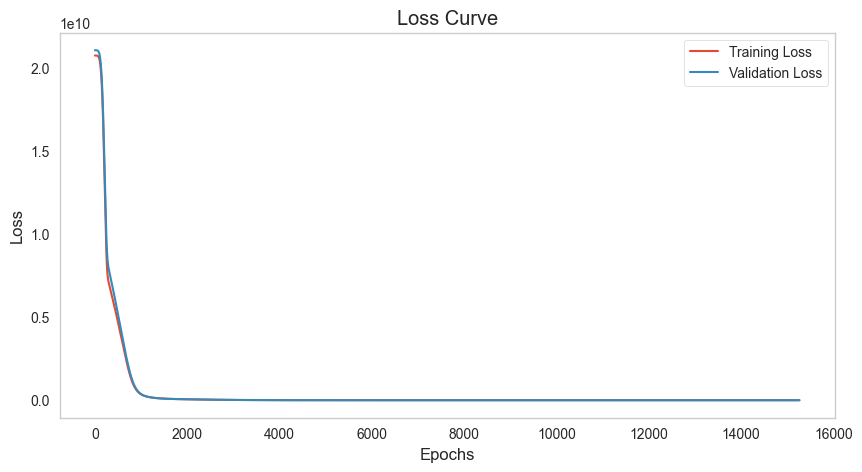

Mean Squared Error (MSE): 2156.511962890625
R^2 Score: 0.9999998211860657


In [86]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load dataset

# Features and target
X = df_cleaned.iloc[:, :-1].values
y = df_cleaned.iloc[:, -1].values

# Data normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Further split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)  # Validation set
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)  # Validation set
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Define the neural network
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.nn.Softplus()( self.fc4(x)) + 100
        return x

# Instantiate the model
input_size = X_train.shape[1]
model = NeuralNet(input_size)

# Define loss function and optimizer
criterion = custom_loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses = []
val_losses = []
# Early stopping parameters
patience = 100
best_loss = np.inf
patience_counter = 0

# Train the model
num_epochs = 30_000
for epoch in range(num_epochs):
    # Forward pass
    model.train()  # Set to training mode
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Validation phase
    model.eval()  # Set to evaluation mode
    with torch.no_grad():
        val_outputs = model(X_val)  # Use validation set
        val_loss = criterion(val_outputs, y_val)  # Use validation targets
    # Record losses
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    
    # Check for best loss and early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        
        if patience_counter >= patience:
            print('Early stopping triggered!')
            break  # Stop training
    if epoch % 200 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')
# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Test the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    y_pred = y_pred.numpy()
    y_test = y_test.numpy()

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R^2 Score: {r2}")

In [87]:
# Test the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
print(y_pred)

tensor([[17158.4141],
        [18560.8730],
        [13629.1836],
        ...,
        [ 3093.1709],
        [ 3853.5842],
        [  800.9017]])


In [88]:
y_test

array([[17151.488],
       [18591.85 ],
       [13656.581],
       ...,
       [ 3117.87 ],
       [ 3875.1  ],
       [  840.85 ]], dtype=float32)

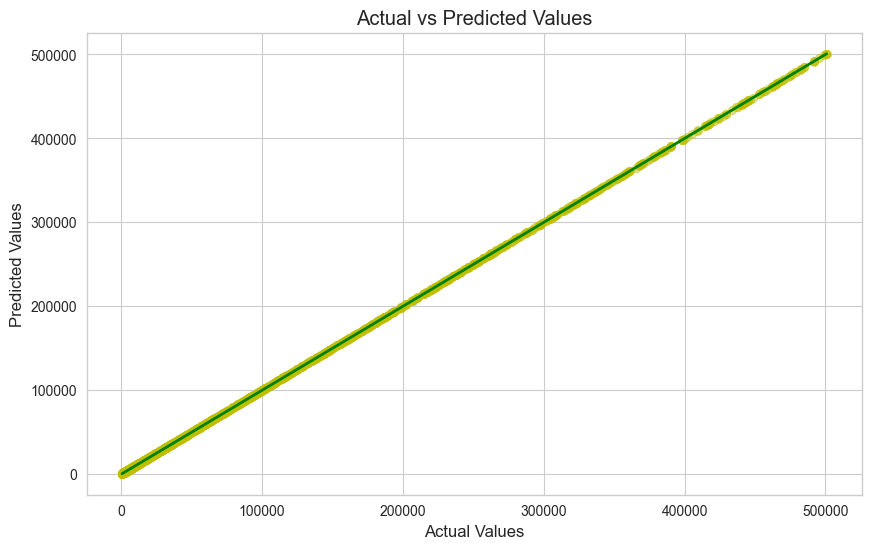

In [89]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, c='y')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'g', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

In [81]:
print(y_test[8][0])

187552.0


In [10]:
arr = []

In [90]:
ret = torch.sum(torch.pow( torch.tensor(y_test) - y_pred, 2))   
arr.append(ret)
arr

[tensor(8859390.), tensor(13840026.), tensor(7100751.), tensor(4716292.)]

In [21]:
int( y_pred.numpy().flatten()[0] ) // 100
# int( y_test.flatten()[0]  ) // 100

171

In [100]:
def calculate_percent(y_pred, y_test ,d):
    n = 10 ** d
    pred = int( y_pred.numpy().flatten() ) // n
    test = int( y_test.flatten()  ) // n
    return pred == test

In [96]:
[sum([calculate_percent(p, t, i) for p, t in zip(y_pred, y_test)]) / len(y_pred) for i in range(-1,5)]


[0.012345679012345678,
 0.012345679012345678,
 0.10608139003200731,
 0.7192501143118427,
 0.9693644261545497,
 0.9981710105166895]

In [107]:
a,b = y_pred.numpy().flatten() / 10, y_test.flatten() /10
a,b

(array([171584.14  , 185608.73  , 136291.83  , ...,  30931.709 ,
         38535.84  ,   8009.0166], dtype=float32),
 array([171514.88 , 185918.5  , 136565.81 , ...,  31178.701,  38751.   ,
          8408.5  ], dtype=float32))

In [110]:
a, b = a.astype(int),b.astype(int)
a,b

(array([171584, 185608, 136291, ...,  30931,  38535,   8009]),
 array([171514, 185918, 136565, ...,  31178,  38751,   8408]))

In [112]:
sum(a == b)/len(a)

np.float64(0.0013717421124828531)

In [101]:
calculate_percent(y_pred, y_test, -1)

TypeError: only length-1 arrays can be converted to Python scalars

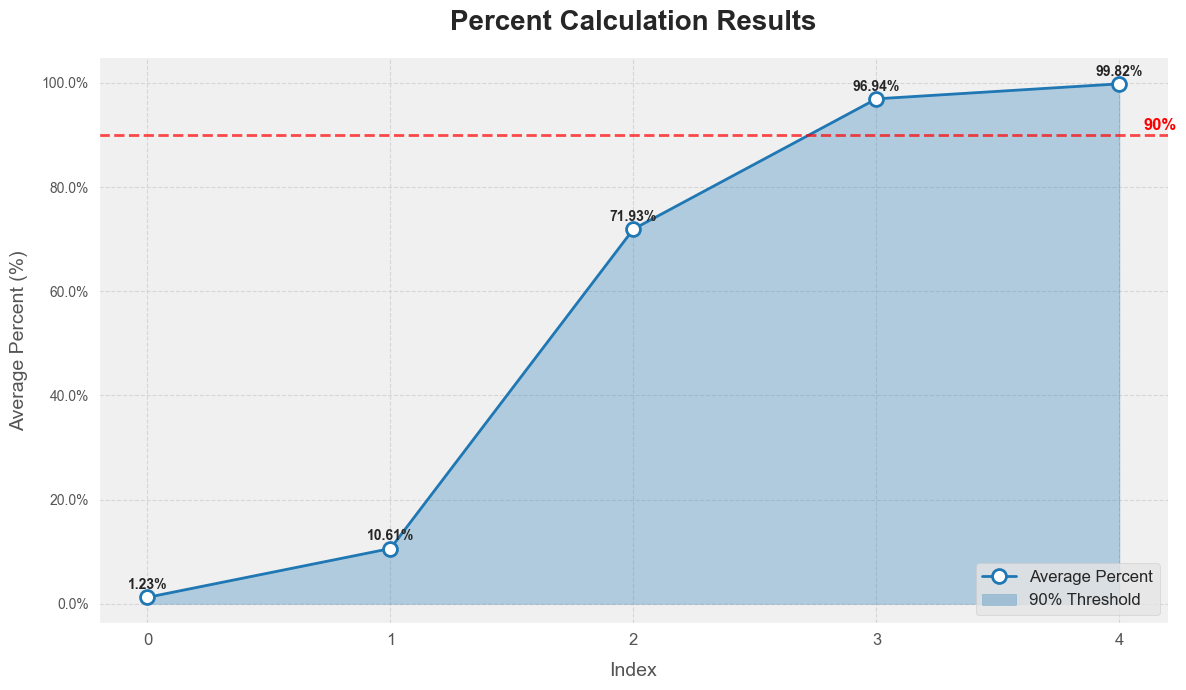

In [95]:
import matplotlib.pyplot as plt
import numpy as np

# 假设你的数据存储在一个列表中，现在我们将其转换为百分比
data = [sum([calculate_percent(p, t, i) for p, t in zip(y_pred, y_test)]) / len(y_pred) * 100 for i in range(5)]

# 设置颜色主题
main_color = '#1f77b4'  # 深蓝色
background_color = '#f0f0f0'  # 浅灰色背景
grid_color = '#cccccc'  # 浅灰色网格线

# 创建一个新图形
plt.figure(figsize=(12, 7))
plt.style.use('ggplot')  # 使用ggplot样式提高美观度

# 绘制主数据线
plt.plot(range(5), data, marker='o', linestyle='-', linewidth=2, color=main_color, 
         markerfacecolor='white', markeredgecolor=main_color, markeredgewidth=2, markersize=10)

# 添加区域填充
plt.fill_between(range(5), data, alpha=0.3, color=main_color)

# 添加标题和标签
plt.title('Percent Calculation Results', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Index', fontsize=14, labelpad=10)
plt.ylabel('Average Percent (%)', fontsize=14, labelpad=10)

# 添加网格
plt.grid(True, linestyle='--', alpha=0.7, color=grid_color)

# 设置x轴和y轴范围
plt.xticks(range(5), fontsize=12)
y_min, y_max = min(data), max(data)
plt.ylim(y_min - 5, y_max + 5)  # 调整y轴范围，为百分比值留出空间

# 添加90%标注线
plt.axhline(y=90, color='red', linestyle='--', linewidth=2, alpha=0.7)
plt.text(4.1, 91, '90%', color='red', fontsize=12, fontweight='bold')

# 为每个数据点添加标签
for i, val in enumerate(data):
    plt.text(i, val + 1, f'{val:.2f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 设置背景颜色
plt.gca().set_facecolor(background_color)

# 添加图例
plt.legend(['Average Percent', '90% Threshold'], loc='lower right', fontsize=12)

# 移除顶部和右侧边框
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# 设置y轴刻度为百分比格式
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.1f}%"))

# 显示图形
plt.tight_layout()
plt.show()

In [91]:
torch.save(model.state_dict(), 'p4_nn_weights.pth')